In [2]:
import scipy as sp
import scipy.io
from scipy import stats
import os
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import roc_curve, auc
import matplotlib.pylab as mpl
from matplotlib import gridspec
import matplotlib.patches as patches
import sys
sys.path.append(os.getcwd()+'\\..')

from utils import auc_methods as am

%load_ext autoreload
%autoreload 2
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 1

In [4]:
bin_size = 0.025
window = [-1, 3]
edges = np.arange(window[0], window[1], bin_size)

In [ ]:
DATA_DIR = os.path.abspath('../data')
log_df = pd.read_hdf(os.path.join(DATA_DIR, 'log_df_processed_02-28-2019.h5'), 'fixed')
unit_key_df = pd.read_hdf(os.path.join(DATA_DIR, 'unit_key_df_processed_02-28-2019.h5'), 'fixed')

In [ ]:
unit_key_df = unit_key_df[~(unit_key_df['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))] # these are mice with tetrodes not implanted in pricipal whisker
unit_key_df['mouse_name'].unique()

In [43]:
def plot_raster(ax,ras,trial_total, window, bin_size = 0.025):
    """
    plot raster for a specific trial_type/outcome stacked on previous plotted raster
    """  
    spike_counts = []
    for trial, spike in enumerate(ras['spike_times(stim_aligned)']):
        spike = spike[(spike>window[0]) & (spike<=window[1])]
        ax.vlines(spike, trial + trial_total - .5, trial + trial_total +.5)
        ax.vlines(ras.iloc[trial]['first_lick'], trial + trial_total - .5, trial +
                   trial_total + .5, color = 'r', linewidth = 5)

        spike = spike[(spike>window[0]) & (spike<=window[1])]
        edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
        count, _ = np.histogram(spike,edges)
        spike_counts.append(count)
    return spike_counts

In [44]:
def plot_psth(spike_counts, ax, window, color, bin_size = 0.025):
    """
    plot psth corresponding to a raster
    """
    average_hist = np.mean(spike_counts, axis=0)/bin_size
    SE_hist = stats.sem(spike_counts)/bin_size
    edges = np.arange(window[0], window[1]+bin_size*2, bin_size)
    ax.plot(edges[0:-1], average_hist, color = color)
    ax.fill_between(edges[0:-1], average_hist-SE_hist, average_hist+SE_hist, alpha = 0.3, color = color)

In [45]:
def plot_rasters_psths(rasters, window, ax, ax1, patch_ax, colors, bin_size = 0.025):
    """
    plot rasters and psths for each trial_type/outcome in "rasters"
    """
    
    trial_total = 1
    patch_ax.plot([0,2],[trial_total-.5, trial_total-.5], '--k')

    for i, ras in enumerate(rasters):
        spike_counts = plot_raster(ax, ras, trial_total, window)
        num_trials_in_raster = len(ras)
        patch_ax.add_patch(patches.Rectangle((0,trial_total -.5), 1,
                                    num_trials_in_raster+1, facecolor = colors[i], alpha = 0.5))

        patch_ax.plot([0,2],[trial_total-.5, trial_total-.5], '--k')
        plot_psth(spike_counts, ax1, window, color = colors[i], bin_size = bin_size)
        trial_total = trial_total + num_trials_in_raster +1

    return spike_counts, trial_total

In [46]:
def plot_raster_fig(rasters, trial_type, window, colors, bin_size = 0.025, ylim_p = None):
    """
    setup figure and plot rasters and PSTHs of indicated unit
    """

    fig = mpl.figure(figsize=(4, 3.5))
    gs = [gridspec.GridSpec(1,1) for i in range(4)]
    gs[0].update(bottom = 0.88, top=0.95, left = 0.2, right = 0.83)
    gs[2].update(bottom=0.15, top=0.41, left = 0.2, right = 0.83)
    gs[1].update(bottom=0.45, top=0.88, left = 0.2, right = 0.83)
    gs[3].update(bottom=0.45, top=0.88, left = 0.83, right = 0.9)

    (ax1, ax2, ax3) = [mpl.subplot(gs[i][0, 0]) for i in range(3)]
    patch_ax = mpl.subplot(gs[3][0, 0], sharey = ax2)

    ax1.add_patch(patches.Rectangle((0,0), 0.15, 0.75, facecolor = 'k', alpha = 0.75))
    spike_counts, trial_total = plot_rasters_psths(rasters, window, ax2,ax3, patch_ax, colors)

    for ax in [ax1,ax2,ax3, patch_ax]:
        ax.set_xlim(window[0],window[1]-bin_size)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    ax1.axis('off')
    ax1.set_ylim(0,2)

    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylabel('Trials')    
    ax2.axes.get_xaxis().set_ticks([])
    ax2.set_ylim(-1, trial_total+.5)

    og_ylim = ax2.get_ylim()
    ax2.spines['left'].set_bounds(0, trial_total)
    ax2.set_yticks(np.arange(0, og_ylim[1], 20))
        
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Firing\nrate (Hz)') 
    if ylim_p != None:
        ax3.set_ylim(ylim_p)

    patch_ax.axis('off')
    patch_ax.set_xlim(0,2)
    return fig

In [47]:
def plot_unit(unit_name, log_df, x_min, x_max, trial_type = 'Stim_Som_NoCue', colors = ['k', 'C0'], ylim=None, bin_size = 0.025):
    """
    indexes trials by trial type and passes them to
    plot_rasters for plotting
    """
    if 'Som' in trial_type:
        resp = 1
    else:
        resp = 2
    
    current_cell = log_df[log_df['uni_id'] == unit_name]
    lick = current_cell[(current_cell['trial_type'] == trial_type) & (current_cell['block_type'] == 'Whisker') & current_cell['response'].isin([resp])]
    no_lick = current_cell[(current_cell['trial_type'] == trial_type) & (current_cell['block_type'] == 'Visual') & current_cell['response'].isin([1,2])]
    rasters = [no_lick, lick]

    fig = plot_raster_fig(rasters, trial_type, [x_min, x_max], colors, ylim_p = ylim, bin_size = bin_size)

    return fig

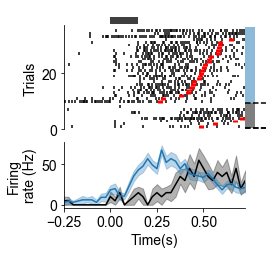

In [83]:
fig = plot_unit('08809-04-167t2', log_df, -0.25, 0.75, trial_type = 'Stim_Som_NoCue', bin_size = bin_size)

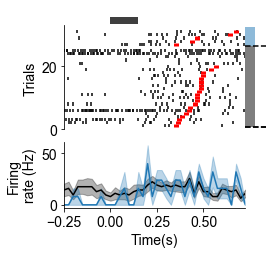

In [82]:
fig = plot_unit('08809-04-167t2', log_df, -0.25, 0.75, trial_type = 'Stim_Vis_NoCue', bin_size = bin_size)

In [14]:
log_df[['uni_id', 'mouse_name', 'date', 'cluster_name']].drop_duplicates().reset_index(drop=True)

,uni_id,mouse_name,date,cluster_name
0,07401-03-161t1,EF0074,01-03-16,TT1clst1
1,07401-03-162t1,EF0074,01-03-16,TT2clst1
2,07401-03-162t2,EF0074,01-03-16,TT2clst2
3,07401-03-165t1,EF0074,01-03-16,TT5clst1
4,07401-03-165t2,EF0074,01-03-16,TT5clst2
...,...,...,...,...
1534,11406-01-187t1,EF0114,06-01-18,TT7clst1
1535,11406-01-187t2,EF0114,06-01-18,TT7clst2
1536,11406-01-187t3,EF0114,06-01-18,TT7clst3
1537,11406-01-188t1,EF0114,06-01-18,TT8clst1


### load auc data

In [5]:
log_df = pd.read_hdf(f'{data_directory}/log_df_processed_02-28-2019.h5', 'fixed')
unit_key_df = pd.read_hdf(f'{data_directory}/unit_key_df_processed_02-28-2019.h5', 'fixed')
unit_key_df = unit_key_df[~(unit_key_df['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))]
log_df = log_df.loc[log_df['uni_id'].isin(unit_key_df['uni_id']),:].reset_index(drop = True)

In [28]:
corr_cols

,uni_id,mouse_name,date,cluster_name
0,07401-03-161t1,EF0074,01-03-16,TT1clst1
1,07401-03-162t1,EF0074,01-03-16,TT2clst1
2,07401-03-162t2,EF0074,01-03-16,TT2clst2
3,07401-03-165t1,EF0074,01-03-16,TT5clst1
4,07401-03-165t2,EF0074,01-03-16,TT5clst2
...,...,...,...,...
1534,11406-01-187t1,EF0114,06-01-18,TT7clst1
1535,11406-01-187t2,EF0114,06-01-18,TT7clst2
1536,11406-01-187t3,EF0114,06-01-18,TT7clst3
1537,11406-01-188t1,EF0114,06-01-18,TT8clst1


In [30]:
tactile_lick_noLick_aucs.reset_index(drop=True)

,RT_mean_TLR,RT_mean_VLL,RT_median_TLR,RT_median_VLL,RT_std_TLR,RT_std_VLL,RT_num_TLR,RT_num_VLL,FR_mean,FR_std,...,conf_lower149,conf_lower150,conf_lower151,conf_lower152,conf_lower153,conf_lower154,conf_lower155,conf_lower156,conf_lower157,conf_lower158
0,0.503702,1.006379,0.391000,0.604750,0.414956,0.810292,39.0,34.0,6.236726,2.312674,...,0.575630,0.495349,0.578125,0.631579,0.578947,0.612500,0.661765,0.671875,0.618182,0.631579
1,0.679468,0.892815,0.530767,0.845567,0.533435,0.552224,49.0,41.0,10.101010,3.050438,...,0.597222,0.589744,0.678788,0.645161,0.578947,0.597561,0.615385,0.617647,0.578947,0.612500
2,0.936456,0.994782,0.493250,0.814633,0.788529,0.664484,88.0,87.0,6.060606,2.755793,...,0.684375,0.716216,0.688657,0.710526,0.829670,0.815789,0.699017,0.743902,0.792683,0.694103
3,0.679468,0.892815,0.530767,0.845567,0.533435,0.552224,49.0,41.0,23.501684,4.182835,...,0.718750,0.583491,0.729730,0.697368,0.647059,0.647475,0.614286,0.594595,0.618421,0.592105
4,0.679468,0.892815,0.530767,0.845567,0.533435,0.552224,49.0,41.0,10.437710,3.068708,...,0.507692,0.686523,0.644444,0.689011,0.487037,0.586813,0.660934,0.658444,0.582176,0.742063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.889032,1.034190,0.441967,0.625100,0.820312,0.835476,67.0,77.0,15.249639,3.858257,...,0.554948,0.522059,0.579310,0.589655,0.666942,0.581967,0.548495,0.624772,0.694114,0.637466
1535,0.889032,1.034190,0.441967,0.625100,0.820312,0.835476,67.0,77.0,8.023088,2.568277,...,0.582812,0.540680,0.615385,0.567708,0.586957,0.558221,0.522879,0.521554,0.643939,0.605952
1536,0.889032,1.034190,0.441967,0.625100,0.820312,0.835476,67.0,77.0,8.392496,3.104073,...,0.540737,0.584848,0.543803,0.612903,0.649123,0.475713,0.545575,0.525112,0.592530,0.595238
1537,0.889032,1.034190,0.441967,0.625100,0.820312,0.835476,67.0,77.0,9.454545,3.085557,...,0.546752,0.515152,0.584324,0.632345,0.491525,0.604598,0.569217,0.527731,0.556604,0.571320


In [31]:
corr_cols = log_df[['uni_id', 'mouse_name', 'date', 'cluster_name']].drop_duplicates().reset_index(drop=True)
tactile_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Som_touch_hit_fa0_2019-09-05.h5_full.h5', 'table').reset_index(drop=True)
tactile_lick_noLick_aucs.loc[:,['uni_id', 'mouse_name', 'date', 'cluster_name']] = corr_cols
visual_lick_noLick_aucs = pd.read_hdf(r'C:\Users\efink\Documents\DATA\Crossmodal_only\Vis_visual_hit_fa0_2019-09-06.h5_full.h5').reset_index(drop=True)
visual_lick_noLick_aucs[['uni_id', 'mouse_name', 'date', 'cluster_name']] = corr_cols

In [32]:
tactile_lick_noLick_aucs['mouse_name'].drop_duplicates().values

array(['EF0074', 'EF0076', 'EF0077', 'EF0079', 'EF0081', 'EF0084',
       'EF0088', 'EF0089', 'EF0114'], dtype=object)

### filter auc data for tactile lick-right/ visual lick-left  data 

In [33]:
tactile_lick_noLick_aucs = tactile_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
visual_lick_noLick_aucs = visual_lick_noLick_aucs.merge(unit_key_df['uni_id'].to_frame(), on = 'uni_id', how = 'right')
visual_lick_noLick_aucs.shape

(1539, 525)

# Identify units with a significant detect probability (DP) and define onset times

In [34]:
auc_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('auc')]
low_conf_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('low')]
up_conf_col_names =tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('up')]

In [35]:
# find bins where auc is significant 
raw_tac_sig_AUC = pd.DataFrame(~((tactile_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).values & 
                    (tactile_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).values)*1, index = tactile_lick_noLick_aucs['uni_id'])

raw_vis_sig_AUC = pd.DataFrame(~((visual_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).values & 
                    (visual_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).values)*1, index = visual_lick_noLick_aucs['uni_id'])

# identify direction of significant bins
auc_dir_t = (tactile_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (tactile_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_t.index = tactile_lick_noLick_aucs['uni_id']; auc_dir_t.columns = raw_tac_sig_AUC.columns
auc_dir_v.index = visual_lick_noLick_aucs['uni_id']; auc_dir_v.columns = raw_vis_sig_AUC.columns

raw_tac_sig_AUC = raw_tac_sig_AUC*auc_dir_t
raw_vis_sig_AUC = raw_vis_sig_AUC*auc_dir_v

In [36]:
# take running sum of bins to identify bins with consecutive significant bins
smooth_tac_sig_AUC = raw_tac_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)
smooth_vis_sig_AUC = raw_vis_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)
smooth_tac_sig_AUC = pd.DataFrame(smooth_tac_sig_AUC.to_dict()).T
smooth_vis_sig_AUC= pd.DataFrame(smooth_vis_sig_AUC.to_dict()).T

### to get the first bin of 2 that are significantly different from 0 need to subtract 1 from all_sig_tac/vis since convolve 
### was used with 'same' setting (otherwise would need to subtract 2 if setting was 'full')
all_sig_tac = (smooth_tac_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_tac = all_sig_tac.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

all_sig_vis = (smooth_vis_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_vis = all_sig_vis.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

### find first significant bin for each unit for each modality
all_first_sig_tac = all_sig_tac.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else []) 
all_first_sig_tac = all_first_sig_tac.apply(lambda y:  np.nan if len(y)==0 else np.min(y))

all_first_sig_vis = all_sig_vis.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else [])
all_first_sig_vis = all_first_sig_vis.apply(lambda y:  np.nan if len(y)==0 else np.min(y))
dp_onsets = pd.merge(all_first_sig_vis.to_frame(name = 'vis_dp_onset').reset_index(), all_first_sig_tac.to_frame(name = 'tac_dp_onset').reset_index(), how = 'outer')
dp_onsets = dp_onsets.rename(columns = {'index': 'uni_id'})

# Find good example units that show range of responses

## sort units either by tac/vis auc ratio or mean auc

In [37]:
nan_rows = tactile_lick_noLick_aucs.loc[:, auc_col_names[0:]].isnull().any(axis = 1)
tactile_lick_noLick_aucs = tactile_lick_noLick_aucs[~nan_rows]
visual_lick_noLick_aucs = visual_lick_noLick_aucs[~nan_rows]

In [38]:
m_tac_cp = tactile_lick_noLick_aucs.loc[:, auc_col_names[39:50]].mean(axis = 1)
m_vis_cp = visual_lick_noLick_aucs.loc[:, auc_col_names[39:50]].mean(axis = 1)

ratio = m_vis_cp.values/m_tac_cp.values
ratio_ind = np.argsort(ratio)

high_mean = m_vis_cp.values*m_tac_cp.values
high_mean_ind = np.argsort(high_mean)[::-1]
                     
sorted_ratio_uni_ids = tactile_lick_noLick_aucs.iloc[ratio_ind]['uni_id']
sorted_mean_uni_ids = tactile_lick_noLick_aucs.iloc[high_mean_ind]['uni_id']

### generators that make flipping through units easy
ratio_unit_gen = (unit for unit in sorted_ratio_uni_ids)
high_mean_unit_gen = (unit for unit in sorted_mean_uni_ids)

In [39]:
### convert onsets to bin indeces
dp_onsets[['tac_dp_onset_inds', 'vis_dp_onset_inds']] = ((dp_onsets[['tac_dp_onset', 'vis_dp_onset']].fillna(-0)+1)/0.025).astype(int)

In [40]:
next(high_mean_unit_gen)

'07602-27-163t1'

08809-04-167t2


(<Figure size 1080x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1d7611f4608>)

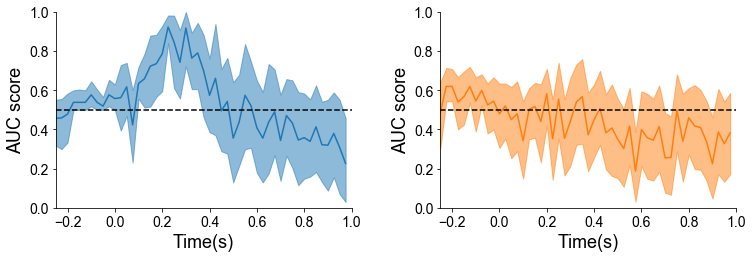

In [81]:
am.plot_auc(next(high_mean_unit_gen), tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-.25,1])

In [ ]:
am.plot_auc('07603-04-162t1', tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-.25,1])

In [ ]:
am.plot_auc('07401-09-164t3', tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-0.25,1])

In [ ]:
am.plot_auc('07903-22-164t2', tactile_lick_noLick_aucs, visual_lick_noLick_aucs, window = [-0.25,1])

In [ ]:
sorted_ratio_uni_ids.index

In [ ]:
import matplotlib.pylab as plt
df = tactile_lick_noLick_aucs.loc[sorted_ratio_uni_ids.index,tactile_lick_noLick_aucs.columns.str.contains('auc')]
plt.imshow(df.iloc[:,15:100], aspect = 'auto', vmin = 0.25, vmax = 0.75)
fig = plt.gcf()
fig.set_size_inches(3,5)

In [ ]:
import matplotlib.pylab as plt
df = visual_lick_noLick_aucs.loc[:,visual_lick_noLick_aucs.columns.str.contains('auc')]
plt.imshow(df.iloc[:,15:100], aspect = 'auto', vmin = 0.25, vmax = 0.75)
fig = plt.gcf()
fig.set_size_inches(3,5)


In [ ]:
import matplotlib.pylab as plt
df = tactile_lick_noLick_aucs.loc[:,tactile_lick_noLick_aucs.columns.str.contains('auc')]
mean_df = df.mean(axis = 0).reset_index(drop=True)
mean_df.iloc[15:75].plot()

In [ ]:
touch_lick_units = dp_onsets.loc[~dp_onsets['tac_dp_onset'].isnull() & dp_onsets['vis_dp_onset'].isnull(), 'uni_id'].to_frame()
vis_lick_units = dp_onsets.loc[~dp_onsets['vis_dp_onset'].isnull() & dp_onsets['tac_dp_onset'].isnull(), 'uni_id'].to_frame()
bimodal_lick_units = dp_onsets.loc[~dp_onsets[['vis_dp_onset', 'tac_dp_onset']].isnull().any(axis = 1), 'uni_id'].to_frame()

In [ ]:
touch_lick_units.loc[touch_lick_units['uni_id'] == '07903-22-164t2', :]

In [ ]:
size_mult = 0.1

In [ ]:
from matplotlib_venn import venn2

fig = mpl.figure(figsize = [10*size_mult,10*size_mult])
v = venn2([touch_lick_units.shape[0], vis_lick_units.shape[0], bimodal_lick_units.shape[0]],
          ('Touch-Lick neurons', 'Visual-Lick neurons'))
v.get_patch_by_id('10').set_color('#7F3F97')
v.get_patch_by_id('01').set_color('C1')
fig.savefig('modality_venn.pdf', format = 'pdf', dpi = 900)

In [ ]:
log_df = pd.read_hdf(f'{data_directory}/log_df_processed_02-28-2019.h5', 'fixed')
unit_key_df = pd.read_hdf(f'{data_directory}/unit_key_df_processed_02-28-2019.h5', 'fixed')
unit_key_df = unit_key_df[~(unit_key_df['mouse_name'].isin(['EF0083','EF0085', 'EF0112', 'EF0111']))]
log_df = log_df.loc[log_df['uni_id'].isin(unit_key_df['uni_id']),:].reset_index(drop = True)

In [ ]:
log_df['uni_id'].drop_duplicates().reset_index(drop=True)

In [ ]:
unit_key_df.loc[0:10, 'uni_id']

In [ ]:
tactile_lick_noLick_aucs['uni_id'].apply(lambda x: (log_df['uni_id'] == x).index)

In [ ]:
corr_inds = unit_key_df.sort_values(by = ['mouse_name', 'date', 'cluster_name']).index

In [ ]:
inds = log_df['uni_id'].drop_duplicates().reset_index()

In [ ]:
inds['index'] = corr_inds

In [ ]:
inds.sort_values('index')

In [86]:
np.random.randint(0,10,10)

array([8, 3, 8, 5, 0, 2, 9, 0, 2, 9])

In [89]:
inds = np.array([[1,2],[1,3]])

In [94]:
y_vals = np.array([9,8,7,5])

In [96]:
y_vals[inds]

array([[8, 7],
       [8, 5]])

In [125]:
x = []

In [126]:
y = np.array([0,1])


In [129]:
x.append(y)

In [131]:
np.vstack(x)

array([[0, 1],
       [0, 1]])

In [133]:
125/4

31.25

In [134]:
31.25*6

187.5

In [135]:
1500/250

6.0

In [141]:
np.random.randint(0, high = 10, size = [10])

array([1, 2, 1, 5, 7, 4, 7, 9, 2, 9])